# Big Ten with AGORA Geometry

This example will consist of the Big Ten benchmark, which includes a reactor cylinder made of enriched uranium, enclosed within a reflector cylinder of uranium.  
We begin by importing the `tripoli5` module and some classes.

In [1]:
%load_ext wurlitzer

In [2]:
from tripoli5.core.euclide import Direction, Point
from tripoli5.core.physics import ParticleType
from tripoli5.core.literals import K, MeV
import tripoli5

## Material Definition
Next, we define the materials for the reactor, the reflector and the surrounding void.  
For that purpose we create mixtures using the `MixtureBuilder`.  
`MixtureBuilder` methods allow defining the various properties of the mixture such as the temperature, density, definition method ("concentrations" in at/barn.cm are used here). 
Three mixtures are defined: `fuel`, `reflector` and `void`.

In [3]:
# Define the materials
fuel_material = "fuel"
reflector_material = "reflector"
void_material = "void"

In [4]:
catalog = tripoli5.delos.Catalog.fromFile(
    f"/opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v{tripoli5.delos.CATALOG_VERSION}.yaml"
)
reactor_mixture = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName(fuel_material)
    .withCatalog(catalog)
    .withTemperature(294 * K)
    .add("U234", 4.8416e-05)
    .add("U235", 4.8151e-03)
    .add("U236", 1.7407e-05)
    .add("U238", 4.3181e-02)
    .build()
)

reflector_mixture = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName(reflector_material)
    .withCatalog(catalog)
    .withTemperature(294 * K)
    .add("U234", 2.8672e-07)
    .add("U235", 1.0058e-04)
    .add("U236", 1.1468e-06)
    .add("U238", 4.7677e-02)
    .build()
)
void_mixture = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName(void_material)
    .withCatalog(catalog)
    .withTemperature(294 * K)
    .add("HE4", 1e-20)
    .build()
)

[2025-09-03 12:41:04.091] [info] Loading catalog from file: /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v2.2.0.yaml
[2025-09-03 12:41:04.119] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-09-03 12:41:04.122] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-09-03 12:41:04.124] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin


## Geometry Definition
Having defined the material let's move on the geometry definition of the problem.  
The geometry of `Big Ten` consists of a reactor cylinder with a radius of 26.67 cm and a half-height of 28.8169 cm, inside a reflector cylinder with a radius of 41.91 cm and a half-height of 48.2600 cm. The system is surrounded by a box of void.


In [5]:
# Define the dimensions
R_reactor = 26.67
R_reflector = 41.91
h_reactor = 28.8169  # Half height
h_reflector = 48.2600  # Half height

# Create the cylinders
reactor_cylinder = tripoli5.agora.ZCylinder(
    0.0, 0.0, R_reactor, label="REACTOR_CYLINDER"
)
reflector_cylinder = tripoli5.agora.ZCylinder(
    0.0, 0.0, R_reflector, label="REFLECTOR_CYLINDER"
)

# Create the ZPlanes for the half-heights
reactor_top_plane = tripoli5.agora.ZPlane(h_reactor, label="REACTOR_TOP_PLANE")
reactor_bottom_plane = tripoli5.agora.ZPlane(-h_reactor, label="REACTOR_BOTTOM_PLANE")
reflector_top_plane = tripoli5.agora.ZPlane(h_reflector, label="REFLECTOR_TOP_PLANE")
reflector_bottom_plane = tripoli5.agora.ZPlane(
    -h_reflector, label="REFLECTOR_BOTTOM_PLANE"
)

# Create the planes for the box
box_xmin_plane = tripoli5.agora.XPlane(-R_reflector, label="BOX_LEFT_PLANE")
box_xmax_plane = tripoli5.agora.XPlane(R_reflector, label="BOX_RIGHT_PLANE")
box_ymin_plane = tripoli5.agora.YPlane(-R_reflector, label="BOX_BOTTOM_PLANE")
box_ymax_plane = tripoli5.agora.YPlane(R_reflector, label="BOX_TOP_PLANE")
box_zmin_plane = tripoli5.agora.ZPlane(-h_reflector, label="BOX_BACK_PLANE")
box_zmax_plane = tripoli5.agora.ZPlane(h_reflector, label="BOX_FRONT_PLANE")

# Define the regions so that they can be re-used at several places
reactor_region = -reactor_cylinder & -reactor_top_plane & +reactor_bottom_plane
# note that defining the reflector_region re-use the reactor_region definition
reflector_region = (
    -reflector_cylinder
    & -reflector_top_plane
    & +reflector_bottom_plane
    & -reactor_region
)
# note that defining the box_region re-use the reflector_region definition
box_region = (
    +box_xmin_plane
    & -box_xmax_plane
    & +box_ymin_plane
    & -box_ymax_plane
    & +box_zmin_plane
    & -box_zmax_plane
)

# Create shapes from regions
reactor_shape = tripoli5.agora.Shape(reactor_region)
reflector_shape = tripoli5.agora.Shape(reflector_region)
void_shape = tripoli5.agora.Shape(-reflector_region & box_region)
outside_shape = tripoli5.agora.Shape(-box_region)

# Create volumes from shapes and materials
reactor = tripoli5.agora.Volume(reactor_shape, fuel_material, label="REACTOR")
reflector = tripoli5.agora.Volume(
    reflector_shape, reflector_material, label="REFLECTOR"
)
void = tripoli5.agora.Volume(void_shape, void_material, label="VOID")
outside = tripoli5.agora.Volume.outside(outside_shape, label="OUTSIDE")

root_universe = tripoli5.agora.Universe([reactor, reflector, void, outside])
geometry = tripoli5.agora.Geometry(root_universe)

Additionally, we can plot the geometry.  
For that purpose, we define a `frame` which select the "window" we want to plot.  
We may (if desired) choose the colors by providing a dictionnary using the `mapping_colors` keyword as shown below.

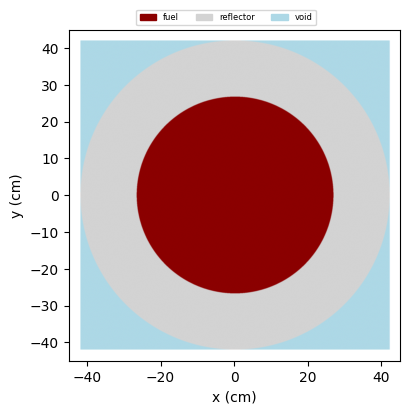

In [6]:
plotter = tripoli5.geoplotter.GeoPlotterPyplot(geometry)
half_length = 45
frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY",
    altitude=0.0,
    u_min=-half_length,
    u_max=half_length,
    v_min=-half_length,
    v_max=half_length,
)

_ = plotter.plot(
    frame=frame,
    mapping_colors={
        "void": "lightblue",
        "fuel": "darkred",
        "reflector": "lightgrey",
    },
)

Alternatively, we may rely on [matplotlib's color map](https://matplotlib.org/stable/users/explain/colors/colormaps.html) to select colors.  
The colormap can be defined using the `color_map` keyword.

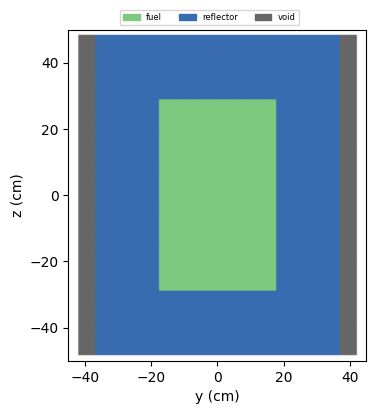

In [7]:
plotter = tripoli5.geoplotter.GeoPlotterPyplot(geometry)
half_length = 45
half_heigth = 50
frame = tripoli5.geoplotter.Frame.fromMinMax(
    "YZ",
    altitude=-20.0,
    u_min=-half_length,
    u_max=half_length,
    v_min=-half_heigth,
    v_max=half_heigth,
)

_ = plotter.plot(
    frame=frame,
    color_map="Accent",
)

## Physics Configuration
The physics models and approximations we want to use in the simulation can be selected at the stage of building the `NeutronMedium`. 
This is achieved using the `NeutronMediumBuilder`, which enables the selection of the physics options and is fed with the material definition (mixtures).  Note that this loads the relevant nuclear data for the simulation. 

Here we use all the default options and turn on the Unresolved Resonance Range Treatment using the probability tables taken from the `ACE` files using the option `ace`.

In [8]:
media = (
    tripoli5.materials.NeutronMediumBuilder()
    .withCatalog(catalog)
    .withMixtures([reactor_mixture, reflector_mixture, void_mixture])
    .withURR("ace")
    .build()
)

[2025-09-03 12:41:08.071] [info] Building HE4 at temperatures: TemperatureRange(294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C])
[2025-09-03 12:41:08.074] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/HE4.294.bin
[2025-09-03 12:41:08.077] [info]   Building free gas collisions at temperature 294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C]
[2025-09-03 12:41:08.078] [info]   Building reaction MTs = 2, 101
[2025-09-03 12:41:08.078] [info] Building U234 at temperatures: TemperatureRange(294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C])
[2025-09-03 12:41:08.080] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/U234.294.bin
[2025-09-03 12:41:08.093] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/urr/njoy_ace/v0.4.0/dir/U234.294.urr.ace.bin
[2025-09-03 12:41:08.096] [info]   Building free gas collisions at temperature 294 [K], 2.5334957256000003e-08 [MeV], 20.85

## Scores

We define a flux score in each volume over an energy grid consisting of 1000 groups defined by equivalent bins in lethargy.  
The class `FluxSpectrumAllVolumes` computes the flux using the track estimator.  
The class `FluxSpectrumCollAllVolumes` computes the flux using the collision estimator.  

In [9]:
flux = tripoli5.score.FluxSpectrumAllVolumes(
    geometry.nb_volumes, 1e-11, 20.0, 1000, "FluxSpectrumAllVolumes"
)
spectrum = tripoli5.score.FluxSpectrumCollAllVolumes(
    geometry.nb_volumes, 1e-11, 20.0, 1000, "FluxSpectrumCollAllVolumes"
)

score_mgr = tripoli5.score.ScoreManager("Bigten-track-and-coll")
score_mgr.addScore(flux)
score_mgr.addScore(spectrum)
score_mgr.initialize("")

## Configure and Run Criticality Calculation
We define an initial source consisting of a spatial uniform distribution in a cyclinder centered in (0., 0., 0.) with a radius of 26.67 cm  and a height of 28.8169 cm. The initial energy of neutrons is set at 2.0 MeV with an isotropic angular distribution. 

In [10]:
src = tripoli5.source.FactorizedSource(
    tripoli5.distributions.spatial.CylinderDistribution(
        Point(0.0, 0.0, 0.0), 26.67, 28.8169
    ),
    tripoli5.distributions.energy.MonoKinetic(2.0 * MeV),
    tripoli5.distributions.angular.IsotropicAngularDistribution(),
    1.0,  # norm
)

Settings for the simulation are defined in a `SimulationParameters` object.   
It contains for instance the number of cycles (batches), the number of particles per cycle, the number of active cycle. 
We define it:

In [11]:
param = tripoli5.simulation.SimulationParameters(
    nb_cycles=110,
    nb_events=10000,  # Particles per cycle
    name="BigTen",
    nb_threads=20,
    discard=10,
)

Finally we assemble the calculation using a simulation object `simu`.  
This is done using a `SimulationBuilder` which allows specifying the calculation mode ("criticality"), the parallelism settings and gather all parameters (geometry, source, media, scores, ...) in the simulation object.  
Then, we can execute the actual simulation by calling the `run()` method. 

In [12]:
simu = (
    tripoli5.simulation.SimulationBuilder(
        simulation_mode="criticality", parallelism_type="openmp"
    )
    .withSource(src)
    .withGeometry(geometry)
    .withMedia("Neutron", media)
    .withParameters(param)
    .withScores(score_mgr)
    .build()
)
simu.run()

[2025-09-03 12:41:08.312] [info] *** Beginning of simulation ***
[2025-09-03 12:41:08.328] [info] Cycle: 1 of 110
[2025-09-03 12:41:08.664] [info]   kstep = 1.06490
[2025-09-03 12:41:08.664] [info]   Mean number of collisions: 28.2212
[2025-09-03 12:41:08.666] [info] Cycle: 2 of 110
[2025-09-03 12:41:08.974] [info]   kstep = 0.95610
[2025-09-03 12:41:08.974] [info]   Mean number of collisions: 30.4813
[2025-09-03 12:41:08.976] [info] Cycle: 3 of 110
[2025-09-03 12:41:09.239] [info]   kstep = 0.97160
[2025-09-03 12:41:09.239] [info]   Mean number of collisions: 30.5141
[2025-09-03 12:41:09.241] [info] Cycle: 4 of 110
[2025-09-03 12:41:09.517] [info]   kstep = 0.97140
[2025-09-03 12:41:09.517] [info]   Mean number of collisions: 31.0948
[2025-09-03 12:41:09.519] [info] Cycle: 5 of 110
[2025-09-03 12:41:09.786] [info]   kstep = 0.98620
[2025-09-03 12:41:09.786] [info]   Mean number of collisions: 31.0149
[2025-09-03 12:41:09.788] [info] Cycle: 6 of 110
[2025-09-03 12:41:10.050] [info]   k

We can extract the $k_{eff}$.

In [13]:
import numpy as np

k_tally = simu.getKStep()
mean = k_tally.mean
std = np.sqrt(k_tally.var)
print(f"k-eff: {mean}±{std}")

k-eff: [0.993415]±[0.00126387]


You may write the results into a CSV file:

In [14]:
flux.writeToFile("Bigten-flux.log")  # Track estimator
spectrum.writeToFile("Bigten-spectrum.log")  # Collision estimator
with open("Bigten-spectrum.log") as f:
    for _ in range(5):
        print(f.readline(), end="")

volume_rank	group_id	E	mean	mean_std
0	0	1e-11	0	0
0	1	1.02873e-11	0	0
0	2	1.05828e-11	0	0
0	3	1.08869e-11	0	0


For now, volumes are identified by a rank.  
They are not linked to volume labels (or materials), so we need to create a table that makes the correspondance between a name and each volume rank.  


In [15]:
materials = geometry.materials
# hack because outside is not listed as a rank
materials.append("outside")
print(materials)

['fuel', 'reflector', 'void', 'outside']


We define a function to plot the flux spectrum for each volume rank from a file by specifying the file name and the title of the graph.

In [16]:
import numpy as np
import matplotlib.pyplot as plt


def plot_flux_spectrum(file_name, title):
    """
    Plots the flux spectrum from a given file.

    Parameters:
    file_name (str): The name of the file containing the data.
    title (str): The title of the graph.
    """
    # Load the data
    data = np.loadtxt(file_name, dtype=float, skiprows=1)

    # Extract columns
    volume_ranks = data[:, 0].astype(int)
    group_ids = data[:, 1].astype(int)
    energies = data[:, 2]
    means = data[:, 3]
    std_devs = data[:, 4]

    # Get unique volume ranks
    unique_volume_ranks = np.unique(volume_ranks)

    # Suppress outside volume
    unique_volume_ranks = unique_volume_ranks[:-1]

    # Define a function to plot the flux spectrum for a given volume rank
    def plot_spectrum(volume_rank, energies, means):
        energies = np.append(energies, 20.0)
        mean_per_lethargy_width = [
            m / (np.log(l2) - np.log(l1))
            for m, l1, l2 in zip(means, energies[:-1], energies[1:])
        ]
        # Hack for step-post proper display
        mean_per_lethargy_width.append(mean_per_lethargy_width[-1])
        plt.plot(
            energies,
            mean_per_lethargy_width,
            linestyle="-",
            linewidth=0.7,
            drawstyle="steps-post",
            label=f"Volume_{materials[volume_rank]}",
        )

    # Plot the flux spectrum for each volume rank
    for volume_rank in unique_volume_ranks:
        mask = volume_ranks == volume_rank
        plot_spectrum(volume_rank, energies[mask], means[mask])

    # Add labels and scale
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Flux per unit lethargy")
    plt.xlim(1e-4, 20)
    plt.xscale("log")
    plt.figtext(0.5, -0.05, title, ha="center", fontsize=12)
    plt.legend()
    plt.show()

We plot the results.

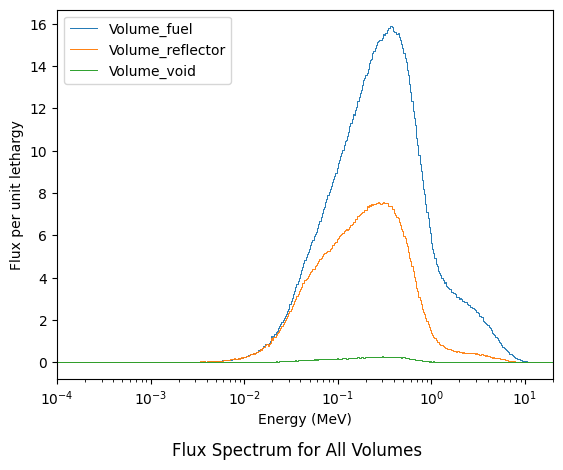

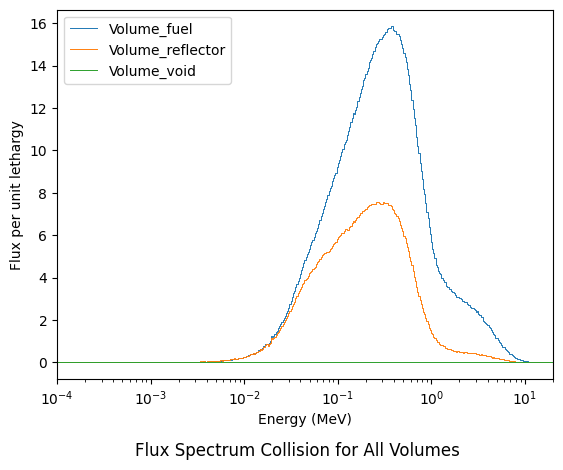

In [17]:
plot_flux_spectrum("Bigten-flux.log", "Flux Spectrum for All Volumes")
plot_flux_spectrum("Bigten-spectrum.log", "Flux Spectrum Collision for All Volumes")